# League of Legends Early Game Classification Analysis

* Student name: Johnny Dryman
* Student pace: full time
* Scheduled project review date/time: 5/27/2021
* Instructor name: James Irving

## Business Problem

League of Legends (LoL) is an intensely competitive game designed for 'core' gamers, or gamers who care deeply about winning the game.  Naturally, these players hate losing.  When I first started playing, I noticed that one of my teammates might "rage quit" a game within the first 10-20 minutes, leaving my teammates and I to an inevitable failure.  This made my experience suffer, and I could see my teammates lamenting in the chat as well.  Considering a single game of LoL can last for 45 minutes, the remaining 35 minutes was not an enjoyable experience.

When I discovered the dataset for League of Legends matches with only the first 10 minutes of data, I was inspired to try and find out whether or not my angry teammates were justified in rage quitting.  Was too much of the 45 minute game decided within the first 10 minutes?  Can I use machine learning to predict the winner with only 10 minutes of data?  What factors in the early game were most likely to lead to a victory?

The goal of this project is to take a look at how well a winner can be predicted based on early game information, and it also seeks to understand what specific factors can predict a victory.

# Data Import and Processing

Importing packages for importing data and exploratory visual analysis.

In [1]:
#Standard python libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings(action='ignore') 

# Preprocessing tools
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate
from sklearn.preprocessing import MinMaxScaler,StandardScaler,OneHotEncoder
scaler = StandardScaler()
from sklearn import metrics

# Models & Utilities
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score

# Warnings
import warnings
warnings.filterwarnings(action='ignore') 



This data was found on Kaggle: https://www.kaggle.com/bobbyscience/league-of-legends-diamond-ranked-games-10-min

In [2]:
# Importing data
df = pd.read_csv('data/high_diamond_ranked_10min.csv')

df.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [3]:
# Taking a look at our columns
print(df.info())

# Checking for NA data
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

Fortunately there are no null values in our dataset.

There are a few columns that can be removed entirely and a few that can be combined into categorical variables.

### First Blood

'First Blood' is awarded to the team who gets the first kill in the game.  Both blueFirstBlood and redFirstBlood are binary and inversely related.  If Blue wins First Blood, blueFirstBlood will be recorded as 1 and redFirstBlood will be recorded as 0.  

We can merge these columns into one.

In [ ]:
df['firstBlood'].head()

In [5]:
firstBlood = []
for item in df['blueFirstBlood']:
    if item == 1:
        firstBlood.append('Blue')
    else:
        firstBlood.append('Red')        
df['firstBlood'] = firstBlood

df['firstBlood'].head()

0       Blue
1        Red
2        Red
3        Red
4        Red
        ... 
9874    Blue
9875     Red
9876     Red
9877    Blue
9878    Blue
Name: firstBlood, Length: 9879, dtype: object

We can discard blueFirstBlood and redFirstBlood

In [6]:
df = df.drop(['blueFirstBlood','redFirstBlood'], axis=1)

### Kills & Deaths

blueKills is inversely related with redDeaths, and redKills is inversely related with blueDeaths since the Blue team can only kill Red players and vice versa.  blueDeaths and redDeaths can both be removed, leaving kills intact will preserve this information.

In [7]:
df = df.drop(['blueDeaths','redDeaths'], axis=1)

### Dragon & Herald

While this wouldn't hold true for LoL data spanning the entire length of each game, we know that there is only one opportunity to kill both the Dragon and the Harold in the first 10 minutes of each match.  Unlike firstBlood where the action always occurs in the first 10 minutes (at least for the matches in our dataset), each dragon or herald can be killed only once or not at all.

Therefore, dragon and herald can be categorized as 'Blue,' 'Red,' or 'None.'

In [8]:
dragon_list = []

dragon_kill = df['blueDragons'] - df['redDragons']

for item in dragon_kill:
    if item == 1:
        dragon_list.append('Blue')
    elif item == -1:
        dragon_list.append('Red')
    else:
        dragon_list.append('No Dragon')
        
df['dragon'] = dragon_list

blueDragons and redDragons can be removed:

In [9]:
df = df.drop(['blueDragons','redDragons'], axis=1)

We can reuse this code for the herald feature:

In [10]:
herald_list = []

herald_kill = df['blueHeralds'] - df['redHeralds']

for item in herald_kill:
    if item == 1:
        herald_list.append('Blue')
    elif item == -1:
        herald_list.append('Red')
    else:
        herald_list.append('No Herald')
        
df['herald'] = herald_list

In [11]:
df = df.drop(['blueHeralds','redHeralds'], axis=1)

### Elite Monsters

In the first 10 minutes of a match, Elite Monsters will receive +1 if a team kills the Dragon and another +1 if the same team kills the Herald.  It is redundant information from what we already have with the Dragon and Harold features.  

In [12]:
df = df.drop(['blueEliteMonsters','redEliteMonsters'], axis=1)

### GoldDiff, ExperienceDiff, CSPerMin, and GoldPerMin

Both blue and red teams have these four metrics.  While they are useful metrics for other types of analyses, they are essentially duplicative, since they are all calculated in a similar fashion from features already included in our data.  

- GoldDiff represents the difference between blueTotalGold and redTotalGold
- ExperienceDiff represents the difference between blueTotalExperience and redTotalExperience
- blue and red CSPerMin represents the minute rate of blue and red TotalMinionsKilled.  For our 10 minute data, CSPerMin for each team will always be TotalMinionsKilled divided by 10
- similarly, blue and red GoldPerMin represents blue and red TotalGold divided by 10

These four features from both teams (totaling 8 features) can be removed without losing any information.


In [13]:
df = df.drop(['blueGoldDiff',
            'blueExperienceDiff',
            'blueCSPerMin',
            'blueGoldPerMin',
            'redGoldDiff',
            'redExperienceDiff',
            'redCSPerMin',
            'redGoldPerMin'], axis=1)

### gameId

gameId represents a unique identifier for every LoL game, no two gameId's will ever be the same, so this column can be removed.

In [14]:
df = df.drop(['gameId'], axis=1)

### Merging Continuous Features

For this analysis, we will combine all blue and red continuous features into single features that will represent that +/- ratio of blue compared to red.  If a continuous value is positive, that means blue had that much more than red.  If a feature is negative, the absolute value of that negative number represents red's greater value.  

In [69]:
# Saving copy of dataframe so far before merging continuous features
df_blue_red = df.copy()

# Instantiating empty dataframe
diff_df = pd.DataFrame()

# Building diff_df by calculating differences between blue and red stats
diff_df['WardsPlaced'] = df['blueWardsPlaced'] - df['redWardsPlaced']
diff_df['WardsDestroyed'] = df['blueWardsDestroyed'] - df['redWardsDestroyed']
diff_df['Kills'] = df['blueKills'] - df['redKills']
diff_df['Assists'] = df['blueAssists'] - df['redAssists']
diff_df['TowersDestroyed'] = df['blueTowersDestroyed'] - df['redTowersDestroyed']
diff_df['TotalGold'] = df['blueTotalGold'] - df['redTotalGold']
diff_df['AvgLevel'] = df['blueAvgLevel'] - df['redAvgLevel']
diff_df['TotalExperience'] = df['blueTotalExperience'] - df['redTotalExperience']
diff_df['TotalMinionsKilled'] = df['blueTotalMinionsKilled'] - df['redTotalMinionsKilled']
diff_df['TotalJungleMinionsKilled'] = df['blueTotalJungleMinionsKilled'] - df['redTotalJungleMinionsKilled']

# Merging with categorical features
diff_df = pd.concat([diff_df, df[['firstBlood', 'dragon', 'herald', 'blueWins']]], axis=1)

diff_df.head()

,WardsPlaced,WardsDestroyed,Kills,Assists,TowersDestroyed,TotalGold,AvgLevel,TotalExperience,TotalMinionsKilled,TotalJungleMinionsKilled,firstBlood,dragon,herald,blueWins
0,13,-4,3,3,0,643,-0.2,-8,-2,-19,Blue,No Dragon,No Herald,0
1,0,0,0,3,-1,-2908,-0.2,-1173,-66,-9,Red,Red,Red,0
2,0,-3,-4,-10,0,-1172,-0.4,-1033,-17,18,Red,Blue,No Herald,0
3,28,-1,-1,-5,0,-1321,0.0,-7,-34,8,Red,No Dragon,Blue,0
4,58,2,0,-1,0,-1004,0.0,230,-15,-10,Red,Red,No Herald,0


# Exploratory Analysis

## Visualizations

Let's run a few visualizations to help us understand the data.  We will use our diff_df, since it's a bit easier to interpret the results.

<AxesSubplot:xlabel='blueWins', ylabel='Count'>

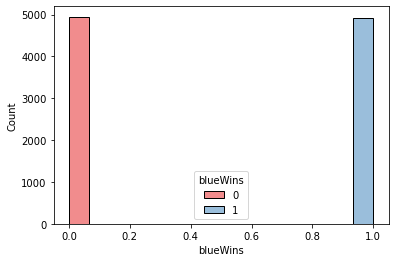

In [16]:
sns.histplot(x='blueWins', data=diff_df, hue='blueWins', palette='Set1', kde=True)

The win split seems pretty even, so it seems there is no overt advantage to being either blue or red.

<AxesSubplot:xlabel='blueKills', ylabel='Count'>

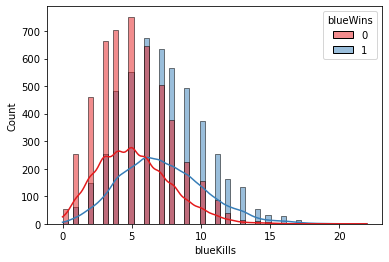

In [68]:
sns.histplot(x='Kills', data=diff_df, hue='blueWins', palette='Set1', kde=True)

It seems clear that outperforming in kills has an influence on winning.

<AxesSubplot:xlabel='Assists', ylabel='Count'>

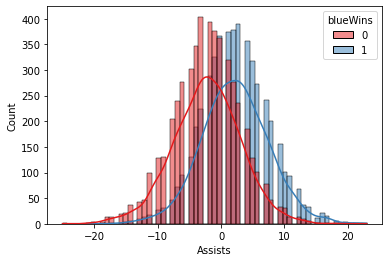

In [18]:
sns.histplot(x='Assists', data=diff_df, hue='blueWins', palette='Set1', kde=True)

Assists still seem relevant and are also somewhat incidental to kills, but the disparity with assists is less clear.

<AxesSubplot:xlabel='dragon', ylabel='count'>

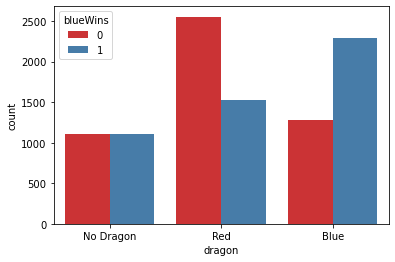

In [19]:
sns.countplot(x='dragon', data=diff_df, hue='blueWins', palette='Set1')


Killing the dragon in the first 10 minutes seems to have a positive influence on winning.  While it might be telling of a win, there are plenty of instances where blue kills the dragon, but red kills the game.  

It's interesting that in the event of no dragon being killed, the victory split for blue and red are nearly identical.

<AxesSubplot:xlabel='herald', ylabel='count'>

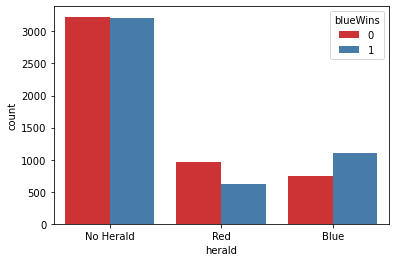

In [20]:
sns.countplot(x='herald', data=diff_df, hue='blueWins', palette='Set1')

There's still an impact for killing the Herald, but it isnt' nearly as significant.  It's also not incredibly common within the first 10 minutes.

<AxesSubplot:xlabel='firstBlood', ylabel='count'>

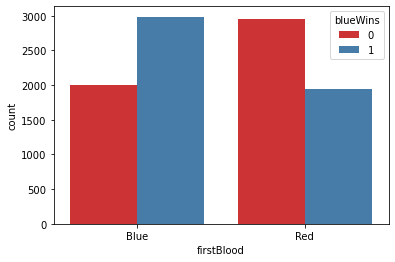

In [21]:
sns.countplot(x='firstBlood', data=diff_df, hue='blueWins', palette='Set1')

First blood is also a notable influencer on victory, but it isn't quite as strong as killing the dragon

<AxesSubplot:xlabel='TotalGold', ylabel='Count'>

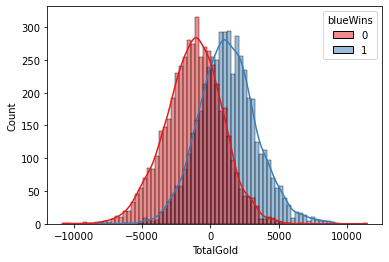

In [22]:
sns.histplot(x='TotalGold', data=diff_df, hue='blueWins', palette='Set1', kde=True)

Gold is also an indicator of victory.  Based on just the graph, it doesn't appear to influnce victory more than kills or assists.

<AxesSubplot:xlabel='WardsPlaced', ylabel='Count'>

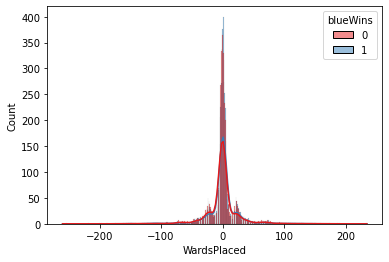

In [23]:
sns.histplot(x='WardsPlaced', data=diff_df, hue='blueWins', palette='Set1', kde=True)

The spread on Wards doesn't seem too telling of a victory.  There's also a significant amount of outliers.

## Multicollinearity

(<Figure size 1080x720 with 2 Axes>, <AxesSubplot:>)

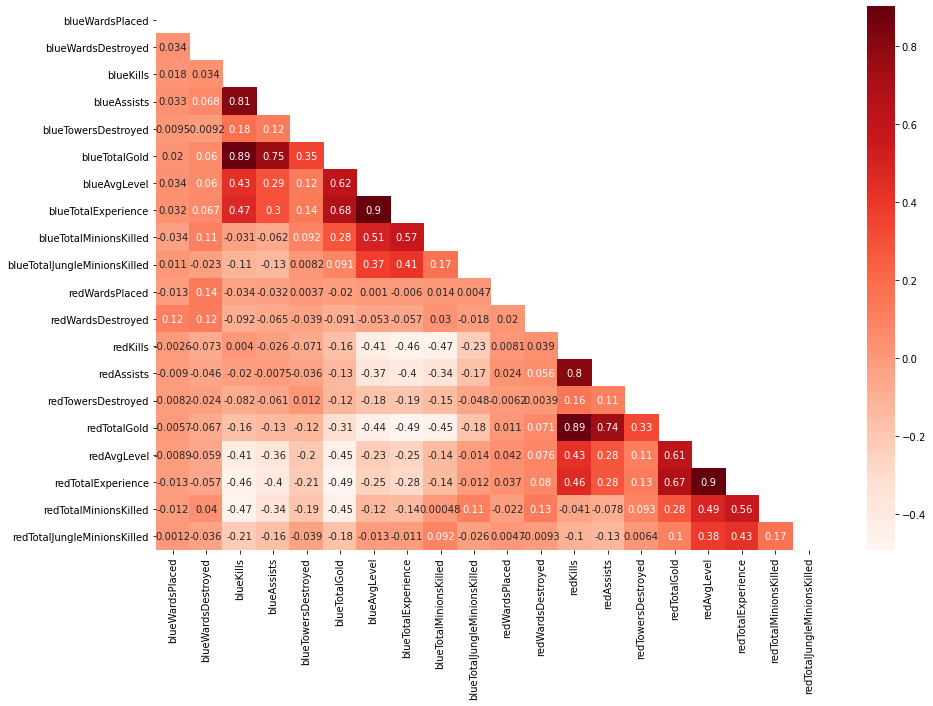

In [66]:
# Create function to output multicollinearity heatmap
def heatmap(df_name, figsize=(15,10), cmap='Reds'):
    corr = df_name.drop('blueWins',axis=1).corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(corr, annot=True, cmap=cmap, mask=mask)
    return fig, ax

heatmap(df)

At first glance, it looks like Gold and Experience / AvgLevel are highly correlated with multiple features.

In [67]:
# Create function to display correlations
# https://pydatascience.org/2019/07/23/remove-duplicates-from-correlation-matrix-python/
def corr_list(df):
    dataCorr = df.drop('blueWins',axis=1).corr()
    dataCorr = dataCorr[abs(dataCorr) >= 0.01].stack().reset_index()
    dataCorr = dataCorr[dataCorr['level_0'].astype(str)!=dataCorr['level_1'].astype(str)]
    dataCorr['ordered-cols'] = dataCorr.apply(lambda x: '-'.join(sorted([x['level_0'],x['level_1']])),axis=1)
    dataCorr = dataCorr.drop_duplicates(['ordered-cols'])
    dataCorr.drop(['ordered-cols'], axis=1, inplace=True)

    return dataCorr.sort_values(by=[0], ascending=False).head(10) #Get 10 highest correlation of pairwaise attributes

corr_list(df)


,level_0,level_1,0
298,redAvgLevel,redTotalExperience,0.901748
113,blueAvgLevel,blueTotalExperience,0.901297
37,blueKills,blueTotalGold,0.888751
224,redKills,redTotalGold,0.885728
35,blueKills,blueAssists,0.813667
222,redKills,redAssists,0.804023
56,blueAssists,blueTotalGold,0.748352
242,redAssists,redTotalGold,0.736215
93,blueTotalGold,blueTotalExperience,0.676193
279,redTotalGold,redTotalExperience,0.669646


Our multicollinearity analysis has presented a few variable relationships that need additional consideration.

- avgLevel and TotalExperience are highly correlated, which is not surprising.  We will keep both for now, but we will also be removing these later in our logistic regression analysis.  
- TotalGold appears consistently in our list.  This is also not surprising since kills and assists award gold.  We will experiment with removing TotalGold for feature analysis.

# MODEL

## Train Test Split

In [27]:
# Isolate target and features
y = df['blueWins']
X = df.drop(columns=['blueWins'], axis=1)

# Create train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

# Confirm split
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (6915, 23)
X_test shape: (2964, 23)


### Categorical Columns

In [28]:
# Separate feautures into continuous and categorical
categoricals = X.select_dtypes('O').columns
numericals = X.select_dtypes('number').columns

# Check output
categoricals, numericals

(Index(['firstBlood', 'dragon', 'herald'], dtype='object'),
 Index(['blueWardsPlaced', 'blueWardsDestroyed', 'blueKills', 'blueAssists',
        'blueTowersDestroyed', 'blueTotalGold', 'blueAvgLevel',
        'blueTotalExperience', 'blueTotalMinionsKilled',
        'blueTotalJungleMinionsKilled', 'redWardsPlaced', 'redWardsDestroyed',
        'redKills', 'redAssists', 'redTowersDestroyed', 'redTotalGold',
        'redAvgLevel', 'redTotalExperience', 'redTotalMinionsKilled',
        'redTotalJungleMinionsKilled'],
       dtype='object'))

In [29]:
# Encode categorical columns, only drop if binary
encoder = OneHotEncoder(sparse=False,drop=None)
train_categoricals = encoder.fit_transform(X_train[categoricals])
test_categoricals = encoder.transform(X_test[categoricals])

# Check output
train_categoricals

array([[1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [30]:
# Convert train and test categoricals into dataframes for merge

train_categoricals_df = pd.DataFrame(train_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

test_categoricals_df =  pd.DataFrame(test_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

# Check output
train_categoricals_df.head()

,firstBlood_Blue,firstBlood_Red,dragon_Blue,dragon_No Dragon,dragon_Red,herald_Blue,herald_No Herald,herald_Red
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


### Numerical Columns

In [31]:
# Scale continuous features and combine into dataframe for merge

scaler = StandardScaler()

train_numericals_df = pd.DataFrame(scaler.fit_transform(X_train[numericals]),
                              columns=numericals)

test_numericals_df = pd.DataFrame(scaler.transform(X_test[numericals]),
                              columns=numericals)

train_numericals_df.head()

,blueWardsPlaced,blueWardsDestroyed,blueKills,blueAssists,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,redWardsPlaced,redWardsDestroyed,redKills,redAssists,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled
0,-0.578888,0.989647,0.933960,0.085648,-0.213734,0.752820,0.267110,0.231218,-0.718868,2.169900,-0.121349,-0.821497,0.644436,0.584197,-0.192021,0.782592,1.560938,1.014104,1.359504,0.077538
1,-0.069037,-0.372949,0.270955,-0.161126,-0.213734,0.163934,-0.385794,-0.068853,-0.489088,0.046285,-0.285904,0.613736,-0.036795,-0.156946,-0.192021,0.899375,0.906406,0.806784,0.626710,1.677757
2,-0.352287,-0.372949,-0.392050,-0.161126,-0.213734,-0.511020,-1.038697,-0.807360,-0.948648,0.956405,-0.340756,0.135325,0.644436,0.337150,-0.192021,-0.073146,-0.402658,-0.020825,0.214513,-2.022750
3,-0.125687,1.898045,1.596965,2.306620,-0.213734,2.111789,0.920013,0.980562,0.705769,-0.257089,-0.340756,0.135325,-1.399258,-1.145137,-0.192021,-1.222855,-1.711722,-1.652635,-1.205276,1.277702
4,-0.465588,0.081250,-0.060548,-0.161126,-0.213734,-0.162866,0.267110,0.412094,0.384077,-1.167209,-0.395608,0.135325,-1.058642,-0.651041,-0.192021,-0.799348,0.251874,-0.225637,-0.747279,0.477592


In [32]:
# Recombine transformed categorical and continuous features, print shape
X_train = pd.concat([train_numericals_df, train_categoricals_df], axis=1)
X_test = pd.concat([test_numericals_df, test_categoricals_df], axis=1)

# Check shape
print(X_train.shape)
print(X_test.shape)

(6915, 28)
(2964, 28)


## Logistic Regression

In [33]:
# Initiate and train model
model_log = LogisticRegression(random_state=8)
model_log.fit(X_train, y_train)

LogisticRegression(random_state=8)

In [34]:
# Test for class imbalance
print(y_train.value_counts(1))
print(y_test.value_counts(1))

1    0.500217
0    0.499783
Name: blueWins, dtype: float64
0    0.503711
1    0.496289
Name: blueWins, dtype: float64


### Accuracy

In [35]:
# Create function for efficient accuracy checks
def model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')

model_accuracy(model_log)

Training Accuracy: 74.04%
Test Accuracy: 71.83%


### Cross Validation Check

In [36]:
# Create cross validation function 
def cross_val_check(model_string_name, model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    scores = cross_val_score(model, X_train, y_train, cv=10) # model, train, target, cross validation
    print(f'{model_string_name} Cross Validation Scores:\n')
    print(scores)
    print(f'\nCross validation mean: \t{scores.mean():.2%}')
    
cross_val_check('Logistic Regression', model_log)

Logistic Regression Cross Validation Scores:

[0.72543353 0.72976879 0.76011561 0.73265896 0.74421965 0.74819103
 0.72793054 0.74674385 0.72937771 0.73082489]

Cross validation mean: 	73.75%


With the highest score at 75.8% and the lowest at 72.5%, we shouldn't be overly concerned with these varying performances calculated with cross validation.

### Confusion Matrix & Classification Report

To save ourself some coding, we'll create a function to report various model metrics.

In [37]:
def evaluate_model(model, X_train=X_train, X_test=X_test, y_train=y_train, 
                   y_test=y_test, cmap='Greens', normalize='true',
                   classes=None,figsize=(10,4)):
    
    # Print model accuracy
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')
    print('')
    
    # Print classification report
    y_test_predict = model.predict(X_test)
    print(metrics.classification_report(y_test, y_test_predict,
                                        target_names=classes))
    
    # Plot confusion matrix
    fig,ax = plt.subplots(ncols=2,figsize=figsize)
    metrics.plot_confusion_matrix(model, X_test,y_test,cmap=cmap, 
                                  normalize=normalize,display_labels=classes,
                                  ax=ax[0])
    
    #Plot ROC curves
    with sns.axes_style("darkgrid"):
        curve = metrics.plot_roc_curve(model,X_train,y_train,ax=ax[1])
        curve2 = metrics.plot_roc_curve(model,X_test,y_test,ax=ax[1])
        curve.ax_.grid()
        curve.ax_.plot([0,1],[0,1],ls=':')
        fig.tight_layout()
        plt.show()

Training Accuracy: 74.04%
Test Accuracy: 71.83%

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1493
           1       0.72      0.72      0.72      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



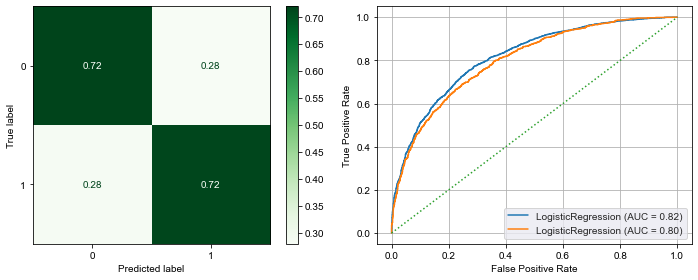

In [38]:
evaluate_model(model_log)

### Dummy Check

It's also important to do a dummy check just to be scientifically certain that we're not arriving at our metrics by chance.

Training Accuracy: 50.22%
Test Accuracy: 49.36%

              precision    recall  f1-score   support

           0       0.50      0.49      0.49      1493
           1       0.49      0.51      0.50      1471

    accuracy                           0.50      2964
   macro avg       0.50      0.50      0.50      2964
weighted avg       0.50      0.50      0.50      2964



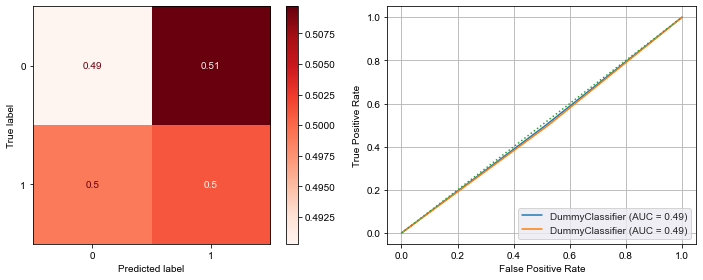

In [39]:
# Create dummy classifier and fit to train / test
dummy = DummyClassifier(strategy='stratified')#,constant=0)
preds = dummy.fit(X_train,y_train).predict(X_test)

evaluate_model(dummy, cmap='Reds')

Based on the dummy, any model we create that performs better than 50% and has a greater AUC than 0.50 would be useful for analysis.

### Hypertuning Logistic Regression

In [40]:
# Initiate new model and perform grid search
model_log_hp = LogisticRegression(random_state=8)

# Define lists of parameters to compare
params = {'C':[0.001,0.01,0.1,1,10,100,1000],
        'penalty':['l1','l2','elastic_net'],
        'solver':["liblinear", "newton-cg", "lbfgs", "sag","saga"]
         }

# Run the grid search with a focus on accuracy
log_grid_search = GridSearchCV(model_log_hp,params,scoring='accuracy')

# Fit grid search to training data and display best parameters
log_grid_search.fit(X_train, y_train)

# Print best parameters
log_grid_search.best_params_

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

Training Accuracy: 74.16%
Test Accuracy: 72.10%

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1493
           1       0.72      0.72      0.72      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



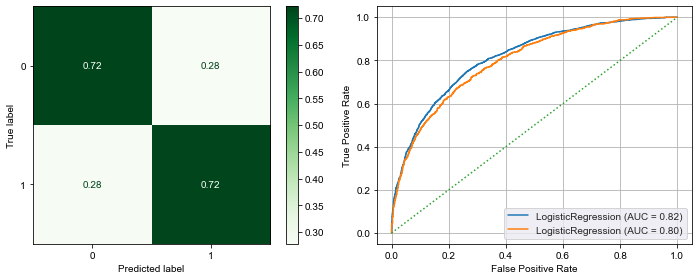

In [41]:
evaluate_model(log_grid_search.best_estimator_)

In [42]:
# Create compare model function

def model_compare(base_model, grid_search_model):
    
    # Calculate accuracies
    base_score = base_model.score(X_test, y_test)
    grid_score = grid_search_model.score(X_test, y_test)
    
    #Print accuracies
    print("--- Base Model ---")
    model_accuracy(base_model)
    print('')
    print("--- Grid Search Model ---")
    model_accuracy(grid_search_model)
    print('')
    
    # If/else function to display best model and score improvement
    if base_score < grid_score:    
        print(f'Our grid search model outperformed our base model by {(grid_score - base_score):.2%}')
    else:
        print(f'Our base model outperformed our grid search model by {(base_score - grid_score):.2%}')
    
model_compare(model_log, log_grid_search.best_estimator_)

--- Base Model ---
Training Accuracy: 74.04%
Test Accuracy: 71.83%

--- Grid Search Model ---
Training Accuracy: 74.16%
Test Accuracy: 72.10%

Our grid search model outperformed our base model by 0.27%


The performance improvement is only marginal, but an improvement nonetheless.  

### Coefficients

Alright!  We can finally dive into the coefficients of our logistic regression model to understand what it believes is most important to predicting the outcome of a match with only 10 minutes worth of data.

Importantly, it can only predict the outcome of a match with 71.83% accuracy.  By comparison, our dummy model was correct 49.49% of the time.  Roughly speaking, this model is ~22% more predictive than flipping a coin.

For analysis, we'll use our basic linear regression model so that we can efficiently recalculate our coefficients as we remove features.

Training Accuracy: 74.04%
Test Accuracy: 71.83%


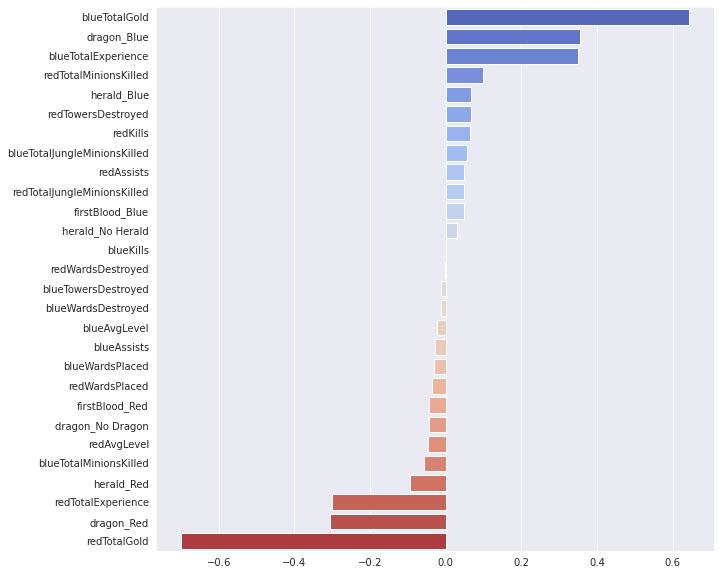

In [43]:
# Create coefficient graph function

def plot_coefficients(X_train, X_test, y_train=y_train, y_test=y_test):    
    
    # Instantiate and train new model
    model = LogisticRegression(random_state=8)
    model.fit(X_train, y_train)
    
    # Create a list of coefficients
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns).sort_values(ascending=False)
    
    # Display accuracy of newly trained model
    model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

    # Create coefficients plot
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(10, 10))
        ax = sns.barplot(x=coeffs, y=coeffs.index, palette='coolwarm')
    
plot_coefficients(X_train, X_test)

Let's first take a look at feature importances using all of our features.

TotalGold is clearly the most predictive feature for victory.  

Earlier, we noticed TotalGold has very high multicollinearity with multiple features.  This isn't surprising, since gold is a resource won from actions taken in the game.  Killing opponents, elite monsters, and creeps all award gold.  

However, it should be pointed out that this model seems to believe that TotalGold will lead to a victory even when Blue is behind in a lot of other key features, like kills, assists, towers, and minions.

This is a bit of a head scratcher.  It's difficult to fathom a situation where blue has more gold than red while also having less kills, assists, and total minions killed.  Perhaps this is a result of our multicollinearity tied to gold and experience.  Let's remove these one by one to see how our coefficients change.

We'll start by dropping TotalGold:

Training Accuracy: 73.32%
Test Accuracy: 71.09%


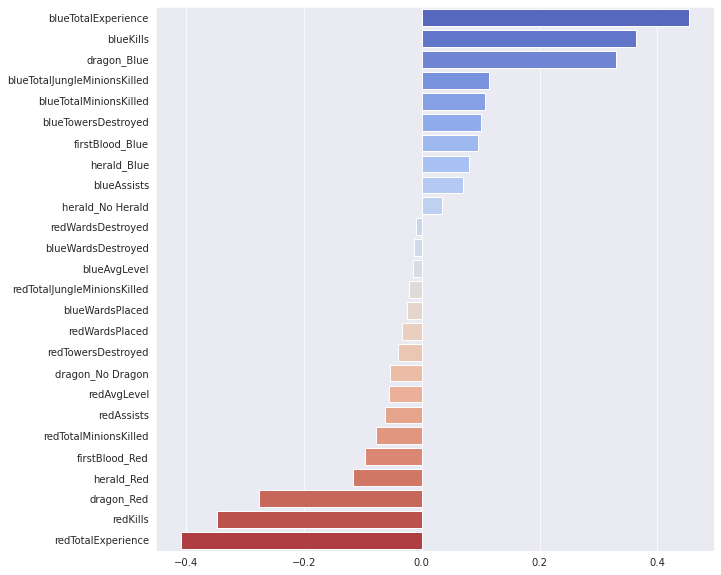

In [44]:
# Drop blue and red TotalGold
X_train_coeff = X_train.drop(['blueTotalGold', 'redTotalGold'],axis=1)
X_test_coeff = X_test.drop(['blueTotalGold', 'redTotalGold'],axis=1)

plot_coefficients(X_train_coeff, X_test_coeff)

These coefficients are a bit more in line with our expectations.  Key in-game performance metrics like kills, dragon, towers, and minions now reflect our general understanding about the game.

TotalExperience is still very high and also correlative with many of our action based metrics.  Let's remove this as well as AvgLevel and see what happens.

Training Accuracy: 72.90%
Test Accuracy: 70.68%


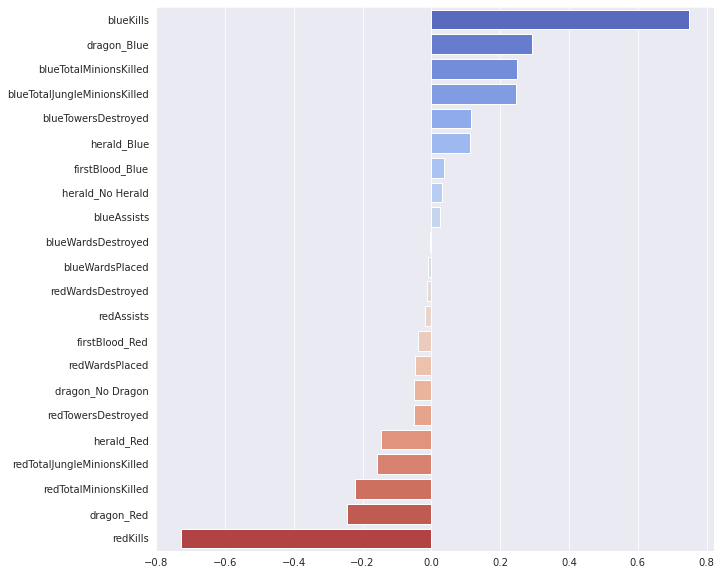

In [45]:
# Drop blue and red TotalGold, TotalExperience, and AvgLevel
X_train_coeff = X_train.drop(['blueTotalGold', 'blueTotalExperience',
                             'redTotalGold', 'redTotalExperience',
                             'blueAvgLevel', 'redAvgLevel'],axis=1)
X_test_coeff = X_test.drop(['blueTotalGold', 'blueTotalExperience',
                             'redTotalGold', 'redTotalExperience',
                             'blueAvgLevel', 'redAvgLevel'],axis=1)

plot_coefficients(X_train_coeff, X_test_coeff)

Finally, we have a visual of coefficients exclusively related to in-game actions.  It is likely that our original model gravitated towards gold because it is a much more precise metric, and it is also a reflection of this action-specific model still values.

Interestingly, the performance for this model 70.48% accurate, which is only 1.21% less accurate than our base model.  

A few observations:

- Outperforming in kills is by far the most important metric in determining a win
- This model values TotalMinionsKilled, dragon_Blue, and TotalJungleMinionsKilled pretty evenly, and they're all significant features
- Herald and towers make a difference, but not as much as dragon and minions (presumably because they contribute more to gold)
- Wards and assists have little impact
- firstBlood for red is slightly predictive of a loss for blue

The graphs above are very useful for visualizing importance, but to quantify, we'll need to convert our coefficients to odds:

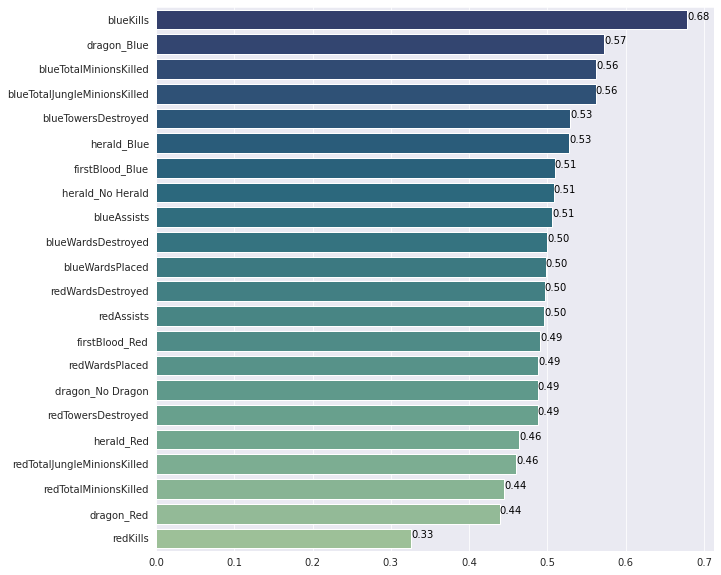

In [46]:
# Initiate model
model = LogisticRegression(random_state=8)
model.fit(X_train_coeff, y_train)

# Return list of coefficients
coeffs = pd.Series(model.coef_.flatten(), index=X_train_coeff.columns).sort_values(ascending=False)

# Convert to odds and to probabilities
odds = np.exp(coeffs)
probs = odds/(1+odds)

# Create probabilities plot
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10, 10))
    ax = sns.barplot(x=probs, y=probs.index, palette='crest_r')

# Add probs values to bar chart
for index, value in enumerate(probs):
    plt.text(value, index,
             str('%.2f' % value))

This chart shows that with any 1 standard deviation increase in each feature, all things remaining the same, the probability of blue winning would increase by that number.  For example:

In [47]:
# Calculate standard deviation of blueKills
df['blueKills'].std().round(2)

3.01

Referring to our probability graph, if blue gets 3 more kills within the first 10 minutes, the probability that blue will win is 68%.

Let's check this again with blueTotalMinions:

In [48]:
# Calculate standard deviation of blueTotalCreeps
df['blueTotalMinionsKilled'].std().round(2)

21.86

All things equal, if blue kills an additional ~22 minions, the probability that it will win improves from our baseline 50% to 57%.

## Random Forest

In [49]:
# Initiate a random forest model
model_rf = RandomForestClassifier(random_state=8)
model_rf.fit(X_train, y_train)

model_accuracy(model_rf)

Training Accuracy: 100.00%
Test Accuracy: 71.59%


In [50]:
cross_val_check('Random Forest', model_rf)

Random Forest Cross Validation Scores:

[0.72543353 0.71965318 0.76589595 0.71387283 0.73265896 0.73227207
 0.70767004 0.72648336 0.72214182 0.70477569]

Cross validation mean: 	72.51%


This is a solid mean, but the wide spread is a bit concerning.  

Training Accuracy: 100.00%
Test Accuracy: 71.59%

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1493
           1       0.72      0.71      0.71      1471

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



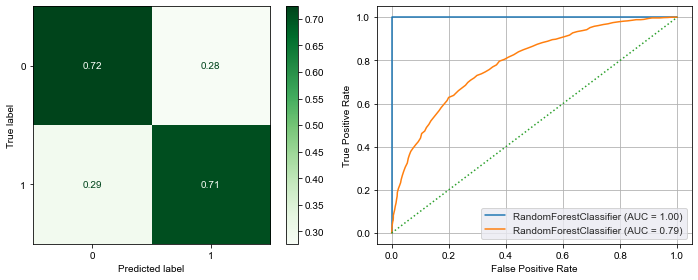

In [51]:
evaluate_model(model_rf)

RF tends to shift away from our categoricals.

### RF Hyperparameter

In [52]:
run = False

# Initiate new random forest model
model_rf_hp = RandomForestClassifier(random_state=8)

# Define grid search parameters
if run == True:
    rf_param_grid = {
        'n_estimators': [10, 30, 100],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 6, 10],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [3, 6]}
else:
    rf_param_grid = {
        'n_estimators': [100],
        'criterion': ['entropy'],
        'max_depth': [6],
        'min_samples_split': [5],
        'min_samples_leaf': [6]}

# Run grid search and fit to train data
rf_grid_search = GridSearchCV(model_rf_hp, rf_param_grid, cv=2, 
#                               verbose=100
                             )
rf_grid_search.fit(X_train, y_train)

# Print metrics
model_compare(model_rf, rf_grid_search.best_estimator_)
print("")
print(f"Cross Validated Score: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

--- Base Model ---
Training Accuracy: 100.00%
Test Accuracy: 71.59%

--- Grid Search Model ---
Training Accuracy: 75.98%
Test Accuracy: 70.72%

Our base model outperformed our grid search model by 0.88%

Cross Validated Score: 73.35%

Optimal Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 100}


The overfitting inherent with random forest search isn't aided too much by the grid search.

### Feature Importances

Training Accuracy: 75.98%
Test Accuracy: 70.72%


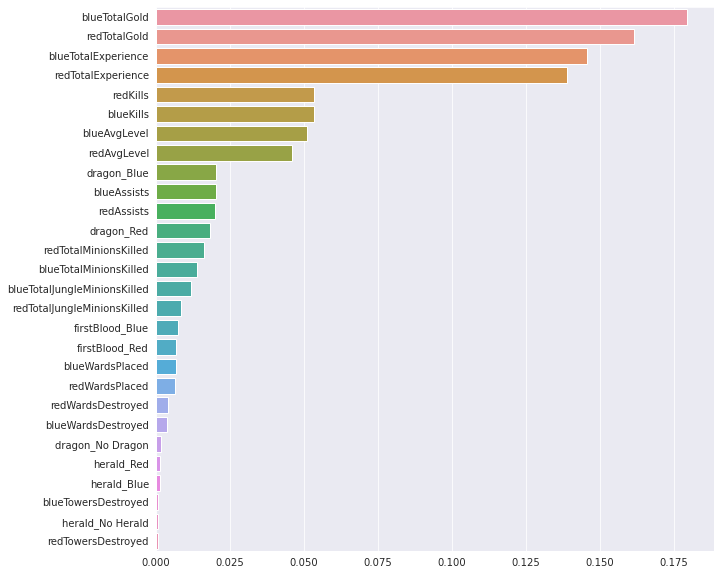

In [53]:
# Create feature importances function for Random Forest and XGboost
def plot_features(model, X_train, X_test, y_train=y_train, y_test=y_test):    
    
    # Create and fit new model
    model = model
    model.fit(X_train, y_train)
    
    # Create a list of feature importances
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    
    # Show model accuracy
    model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    
    # Plot feature importance
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(10, 10))
        ax = sns.barplot(x=feature_importance, y=feature_importance.index)

# Create a new model for our function with grid search best parameters
rf_model = RandomForestClassifier(**rf_grid_search.best_params_, random_state=8)
    
plot_features(rf_model, X_train, X_test)


Training Accuracy: 75.27%
Test Accuracy: 70.01%


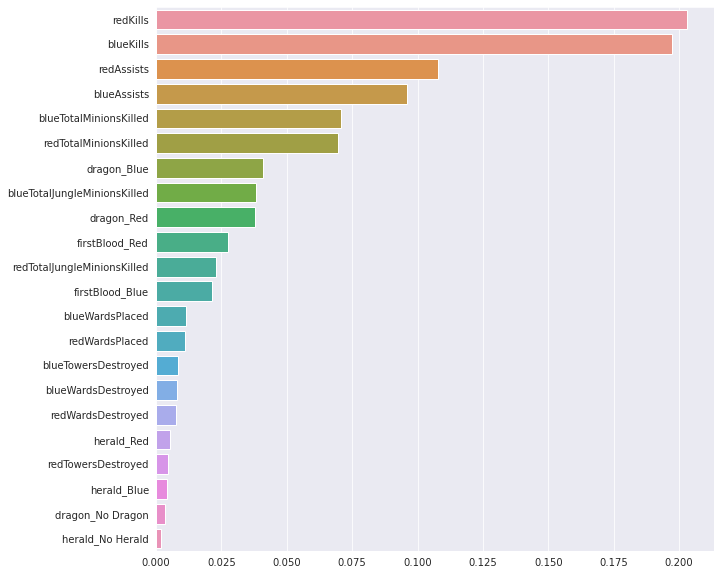

In [54]:
plot_features(rf_model, X_train_coeff, X_test_coeff)

## XGBoost

In [55]:
# Initiate and train XGB model
model_xgb = XGBClassifier(random_state=8)
model_xgb.fit(X_train, y_train)

model_accuracy(model_xgb)

Training Accuracy: 96.56%
Test Accuracy: 69.23%


In [56]:
cross_val_check('XGBoost', model_xgb)

XGBoost Cross Validation Scores:

[0.71965318 0.69653179 0.71531792 0.69075145 0.7066474  0.6975398
 0.7105644  0.723589   0.6845152  0.70622287]

Cross validation mean: 	70.51%


In [ ]:
run = False

# Initiate new random forest model
model_rf_hp = RandomForestClassifier(random_state=8)

# Define grid search parameters
if run == True:
    rf_param_grid = {
        'n_estimators': [10, 30, 100],
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 2, 6, 10],
        'min_samples_split': [5, 10],
        'min_samples_leaf': [3, 6]}
else:
    rf_param_grid = {
        'n_estimators': [100],
        'criterion': ['entropy'],
        'max_depth': [6],
        'min_samples_split': [5],
        'min_samples_leaf': [6]}

# Run grid search and fit to train data
rf_grid_search = GridSearchCV(model_rf_hp, rf_param_grid, cv=2, 
#                               verbose=100
                             )
rf_grid_search.fit(X_train, y_train)

# Print metrics
model_compare(model_rf, rf_grid_search.best_estimator_)
print("")
print(f"Cross Validated Score: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

In [57]:
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10, 100, 1000]}


In [58]:
run = False

if run == True:

    model_xgb_hp = XGBClassifier(random_state=8)

    xgb_grid_search = GridSearchCV(model_xgb_hp, param_grid, scoring='accuracy', cv=None, n_jobs=-1, verbose=100)
    xgb_grid_search.fit(X_train, y_train)

    model_accuracy(xgb_grid_search)
    
    xgb_best_parameters = xgb_grid_search.best_params_

    print(f"Cross Validated Score: {xgb_grid_search.best_score_ :.2%}")
    print("")
    print(f"Optimal Parameters: {xgb_grid_search.best_params_}")
    
else:
    xgb_best_parameters = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.5,
    'n_estimators': 100
    }

    model_xgb_hp = XGBClassifier(**xgb_best_parameters, random_state=8)
    model_xgb_hp.fit(X_train, y_train)
    model_compare(model_xgb, model_xgb_hp)

--- Base Model ---
Training Accuracy: 96.56%
Test Accuracy: 69.23%

--- Grid Search Model ---
Training Accuracy: 74.36%
Test Accuracy: 71.09%

Our grid search model outperformed our base model by 1.86%


Training Accuracy: 71.67%
Test Accuracy: 70.04%


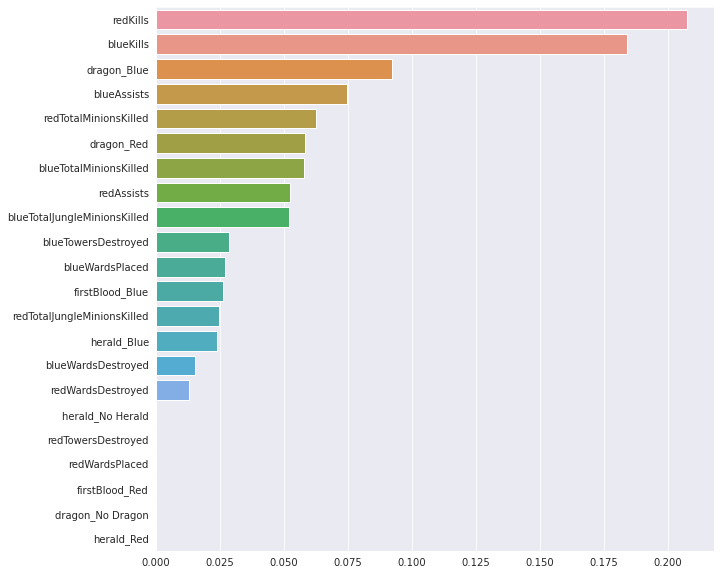

In [64]:
plot_features(model_xgb_hp, X_train_coeff, X_test_coeff)

Training Accuracy: 74.36%
Test Accuracy: 71.09%


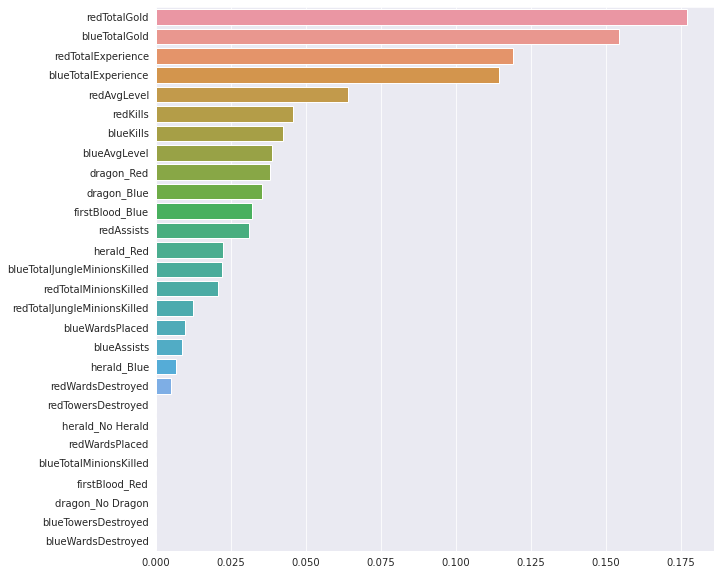

In [65]:
plot_features(model_xgb_hp, X_train, X_test)

# iNTERPRET

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

# CONCLUSIONS & RECOMMENDATIONS

Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

In [ ]:

# Create function used to find Precision, Recall, Accuracy, and F1 Scores.
def print_metrics(labels, preds):
    print("Precision Score: {}".format(precision_score(labels, preds)))
    print("Recall Score: {}".format(recall_score(labels, preds)))
    print("Accuracy Score: {}".format(accuracy_score(labels, preds)))
    print("F1 Score: {}".format(f1_score(labels, preds)))
    

            
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

# Create a function that visualizes the confusion matrix for the model.    
def plot_cm(model, normalize='true'):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.grid(False)
    plot_confusion_matrix(model, X_test, y_test, cmap='Blues', ax=ax, normalize=normalize)


In [ ]:
def tt_split_df(df):
    
    y = df['blueWins']
    X = df.drop(columns=['blueWins'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    X_train_tf = X_train.copy()
    X_test_tf = X_test.copy()
    
    categoricals = X.select_dtypes('O').columns
    numericals = X.select_dtypes('number').columns
    
    encoder = OneHotEncoder(sparse=False,drop='if_binary')
    train_categoricals = encoder.fit_transform(X_train_tf[categoricals])
    test_categoricals = encoder.transform(X_test_tf[categoricals])
    
    train_categoricals_df = pd.DataFrame(train_categoricals,
                                     columns=encoder.get_feature_names(categoricals))

    test_categoricals_df =  pd.DataFrame(test_categoricals,
                                     columns=encoder.get_feature_names(categoricals))
    train_numericals_df = pd.DataFrame(scaler.fit_transform(X_train_tf[numericals]),
                              columns=numericals)

    test_numericals_df = pd.DataFrame(scaler.transform(X_test_tf[numericals]),
                              columns=numericals)
    
    X_train_tf = pd.concat([train_numericals_df, train_categoricals_df], axis=1)
    X_test_tf = pd.concat([test_numericals_df, test_categoricals_df], axis=1)
    
    return X_train_tf, X_test_tf, y_train, y_test

# tt_split_df(diff_df)

X_train, X_test, y_train, y_test = tt_split_df(df)

In [ ]:
# Initiate and train model
def model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    print(f'Training Accuracy: {model.score(X_train,y_train):.2%}')
    print(f'Test Accuracy: {model.score(X_test,y_test):.2%}')

# model_accuracy(model_log)


model_log = LogisticRegression()

model_log.fit(X_train, y_train)

model_accuracy(model_log, X_train=X_train, X_test=X_test)

In [ ]:
X_train_br

In [ ]:
X_train_br, X_test_br, y_train, y_test = tt_split_df(df_blue_red)

mod = LogisticRegression()

mod.fit(X_train_br, y_train)

model_accuracy(mod, X_train=X_train_br, X_test=X_test_br)
# model_accuracy(mod)

In [ ]:
param_grid = {
    'learning_rate': [0.0001, 0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7, 1],
    'n_estimators': [10, 100, 1000]}


In [ ]:
run = True

if run == True:

    model_xgb_hp = XGBClassifier()

    xgb_grid_search = GridSearchCV(model_xgb_hp, param_grid, scoring='accuracy', cv=None, n_jobs=-1, verbose=100)
    xgb_grid_search.fit(X_train, y_train)

    model_accuracy(xgb_grid_search)
    
    xgb_best_parameters = xgb_grid_search.best_params_

    print(f"Cross Validated Score: {xgb_grid_search.best_score_ :.2%}")
    print("")
    print(f"Optimal Parameters: {xgb_grid_search.best_params_}")
    
else:
    xgb_best_parameters = {
    'learning_rate': 0.01,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.5,
    'n_estimators': 100
    }

    model_xgb_hp = XGBClassifier(**xgb_best_parameters)
    model_xgb_hp.fit(X_train, y_train)
    model_accuracy(model_xgb_hp, X_train=X_train_br, X_test=X_test_br)

In [ ]:
model_accuracy(xgb_grid_search)

In [ ]:
model_xgb_hp = XGBClassifier(**xgb_best_parameters)
model_xgb_hp.fit(X_train_br, y_train)
model_accuracy(model_xgb_hp, X_train=X_train_br, X_test=X_test_br)

In [ ]:
xgb_grid_search

In [ ]:
model_xgb_hp = XGBClassifier(**xgb_best_parameters)
model_xgb_hp.fit(X_train_br, y_train)
model_accuracy(xgb_grid_search, X_train=X_train_br, X_test=X_test_br)

In [ ]:
# Create coefficient graph function

def plot_coefficients(X_train, X_test, y_train=y_train, y_test=y_test):    
    model = LogisticRegression(random_state=8)
    model.fit(X_train, y_train)
    coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns).sort_values(ascending=True)
    model_accuracy(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
    ax = coeffs.plot(kind='barh', figsize=(8,6))
    
    

Let's first take a look at feature importances using all of our features.

In [ ]:
plot_coefficients(X_train, X_test)

TotalGold is clearly the most predictive feature for victory.  

Earlier, we noticed TotalGold has very high multicollinearity with multiple features.  This isn't surprising, since gold is a resource won from actions taken in the game.  Killing opponents, elite monsters, and creeps all award gold.  

However, it should be pointed out that this model seems to believe that TotalGold will lead to a victory even when Blue is behind in a lot of other key features, like kills, assists, towers, and minions.

This is a bit of a head scratcher.  It's difficult to fathom a situation where blue has more gold than red while also having less kills, assists, and total minions killed.  Perhaps this is a result of our multicollinearity tied to gold and experience.  Let's remove these one by one to see how our coefficients change.

We'll start by dropping TotalGold:

In [ ]:
X_train_coeff = X_train.drop(['TotalGold'],axis=1)
X_test_coeff = X_test.drop(['TotalGold'],axis=1)

plot_coefficients(X_train_coeff, X_test_coeff)

These coefficients are a bit more in line with our expectations.  Key in-game performance metrics like kills, dragon, towers, and minions now reflect our general understanding about the game.

TotalExperience is still very high and also correlative with many of our action based metrics.  Let's remove it and see what happens.

In [ ]:
X_train_coeff = X_train.drop(['TotalGold', 'TotalExperience'],axis=1)
X_test_coeff = X_test.drop(['TotalGold', 'TotalExperience'],axis=1)

plot_coefficients(X_train_coeff, X_test_coeff)

The picture is becoming more clear, but AvgLevel was also highly correlative with other features, and it is also a direct reflection of TotalExperience and therefore highly reflective of other action based metrics.  Let's remove it.

In [ ]:
X_train_coeff = X_train.drop(['TotalGold', 'TotalExperience', 'AvgLevel'],axis=1)
X_test_coeff = X_test.drop(['TotalGold', 'TotalExperience', 'AvgLevel'],axis=1)

plot_coefficients(X_train_coeff, X_test_coeff)

Finally, we have a visual of coefficients exclusively related to in-game actions.  It is likely that our original model gravitated towards gold because it is a much more precise metric, and it is also a reflection of this action-specific model still values.

Interestingly, the performance for this model 70.48% accurate, which is only 1.21% less accurate than our base model.  

A few observations:

- Outperforming in kills is by far the most important metric in determining a win
- This model values TotalMinionsKilled, dragon_Blue, and TotalJungleMinionsKilled pretty evenly, and they're all significant features
- Herald and towers make a difference, but not as much as dragon and minions (presumably because they contribute more to gold)
- Wards and assists have little impact
- firstBlood for red is slightly predictive of a loss for blue

The graphs above are very useful for visualizing importance, but to quantify, we'll need to convert our coefficients to odds:

In [ ]:
# Initiate model

model = LogisticRegression(random_state=8)

model.fit(X_train_coeff, y_train)

# Return list of coefficients

coeffs = pd.Series(model.coef_.flatten(), index=X_train_coeff.columns).sort_values(ascending=True)

# Convert to odds

odds = np.exp(coeffs)

# Plot bar chart

ax = odds.plot(kind='barh', figsize=(8,6))

# Add odds values to bar chart

for index, value in enumerate(odds):
    plt.text(value, index,
             str('%.2f' % value))

# Create vertical line at x = 1
    
ax.axvline(1)

model.intercept_

For every 1 standard deviation increase in Kills, the odds that blue will win is 2.82 times greater than the odds that they lost.  

In [ ]:
df['TotalMinionsKilled'].std().round(2)

In [ ]:
coeffs

In [ ]:
def prob_feature(feature, model=model, df=df, coeffs=coeffs):

    intercept = model.intercept_

    feature_sd = df[str(feature)].std()
    
    feature_coeff = coeffs[str(feature)]
    
    odds = (intercept * 1) + (feature_sd * 1)
    probs = odds/(1+odds)
    
    return probs
    
prob_feature('blueKills')

In [ ]:
feature_sd = df['blueKills'].std()
feature = 'blueKills'
feature_coeff = coeffs['blueKills']

sumprod1 = (model.intercept_ * 1) + (feature_coeff * 1)
sumprod2 = (model.intercept_ * 1) + (feature_coeff * 2)
sumprod3 = (model.intercept_ * 1) + (feature_coeff * 3)

prob1 = np.exp(sumprod1) / (np.exp(sumprod1) + 1)
prob2 = np.exp(sumprod2) / (np.exp(sumprod2) + 1)
prob3 = np.exp(sumprod3) / (np.exp(sumprod3) + 1)

print(f'For every 1 standard deviation increase in {feature})

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
# import shap
from matplotlib import pyplot as plt


plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_coeff, y_train)

sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train_coeff.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [ ]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")